In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from tqdm import tqdm
import seaborn as sns
import sys
sys.path.append("../")
import util
import importlib
importlib.reload(util)

from util import util_functions
from util.util_functions import PreprocessInfo
from util.util_functions import ClusteringExperiment

px = 1/plt.rcParams["figure.dpi"]
plt.rcParams['figure.figsize'] = [1848*px, 965*px]
c = ["#007fff", "#ff3616", "#138d75", "#7d3c98", "#fbea6a"]  # Blue, Red, Green, Purple, Yellow

sns.set(
    style="ticks",
    rc={
        "font.family": "Arial",
        "font.size": 40,
        "axes.linewidth": 2,
        "lines.linewidth": 5,
    },
    font_scale=2.5,
    palette=sns.color_palette("Set2")
)
CONDUCTANCE_LABEL = r"Conductance (log$_{10}$(G/G$_0$))"
ALPHABET = "ABCDEFGHIJKLMNOPQ"
RNG_STATE = 42
FONTSIZE = 48

In [2]:
blank_traces = np.load("./blanks_all_traces.npy", allow_pickle=True)
molecular_traces = np.load("./all_traces.npy", allow_pickle=True)

In [3]:
pre_info = PreprocessInfo(
    high=-1.0,
    low=-5.0,
    plot_high=-.5,
    plot_low=-5,
    bins=128,
    bins_2d=(64, 64),
    hist2d_length=1024,
)

In [4]:
fullwindow_blanks, p_blanks = util_functions.rt_preprocessing(blank_traces[:len(blank_traces) // 2 + 1024*2], pre_info, longest_cutoff=6_000, apply_log=False)
fullwindow_molecular, p_molecular = util_functions.rt_preprocessing(molecular_traces, pre_info, longest_cutoff=6_000, apply_log=False)

hist_blanks, hist_blanks2d = util_functions.get_histograms(
    p_blanks, low=pre_info.low, high=pre_info.high, pre_info=pre_info
)
hist_molecular, hist_molecular2d = util_functions.get_histograms(
    p_molecular, low=pre_info.low, high=pre_info.high, pre_info=pre_info
)

plot_hist_blanks, plot_hist_blanks2d = util_functions.get_histograms(
    p_blanks, low=pre_info.plot_low, high=pre_info.plot_high, pre_info=pre_info
)
plot_hist_molecular, plot_hist_molecular2d = util_functions.get_histograms(
    p_molecular, low=pre_info.plot_low, high=pre_info.plot_high, pre_info=pre_info
)

100%|██████████| 12010/12010 [00:00<00:00, 25817.57it/s]


Amount discarded: 0


100%|██████████| 24895/24895 [00:01<00:00, 24200.88it/s]


Amount discarded: 1430


Generating 1D- and 2D histograms: 100%|██████████| 23465/23465 [00:07<00:00, 3049.24it/s]


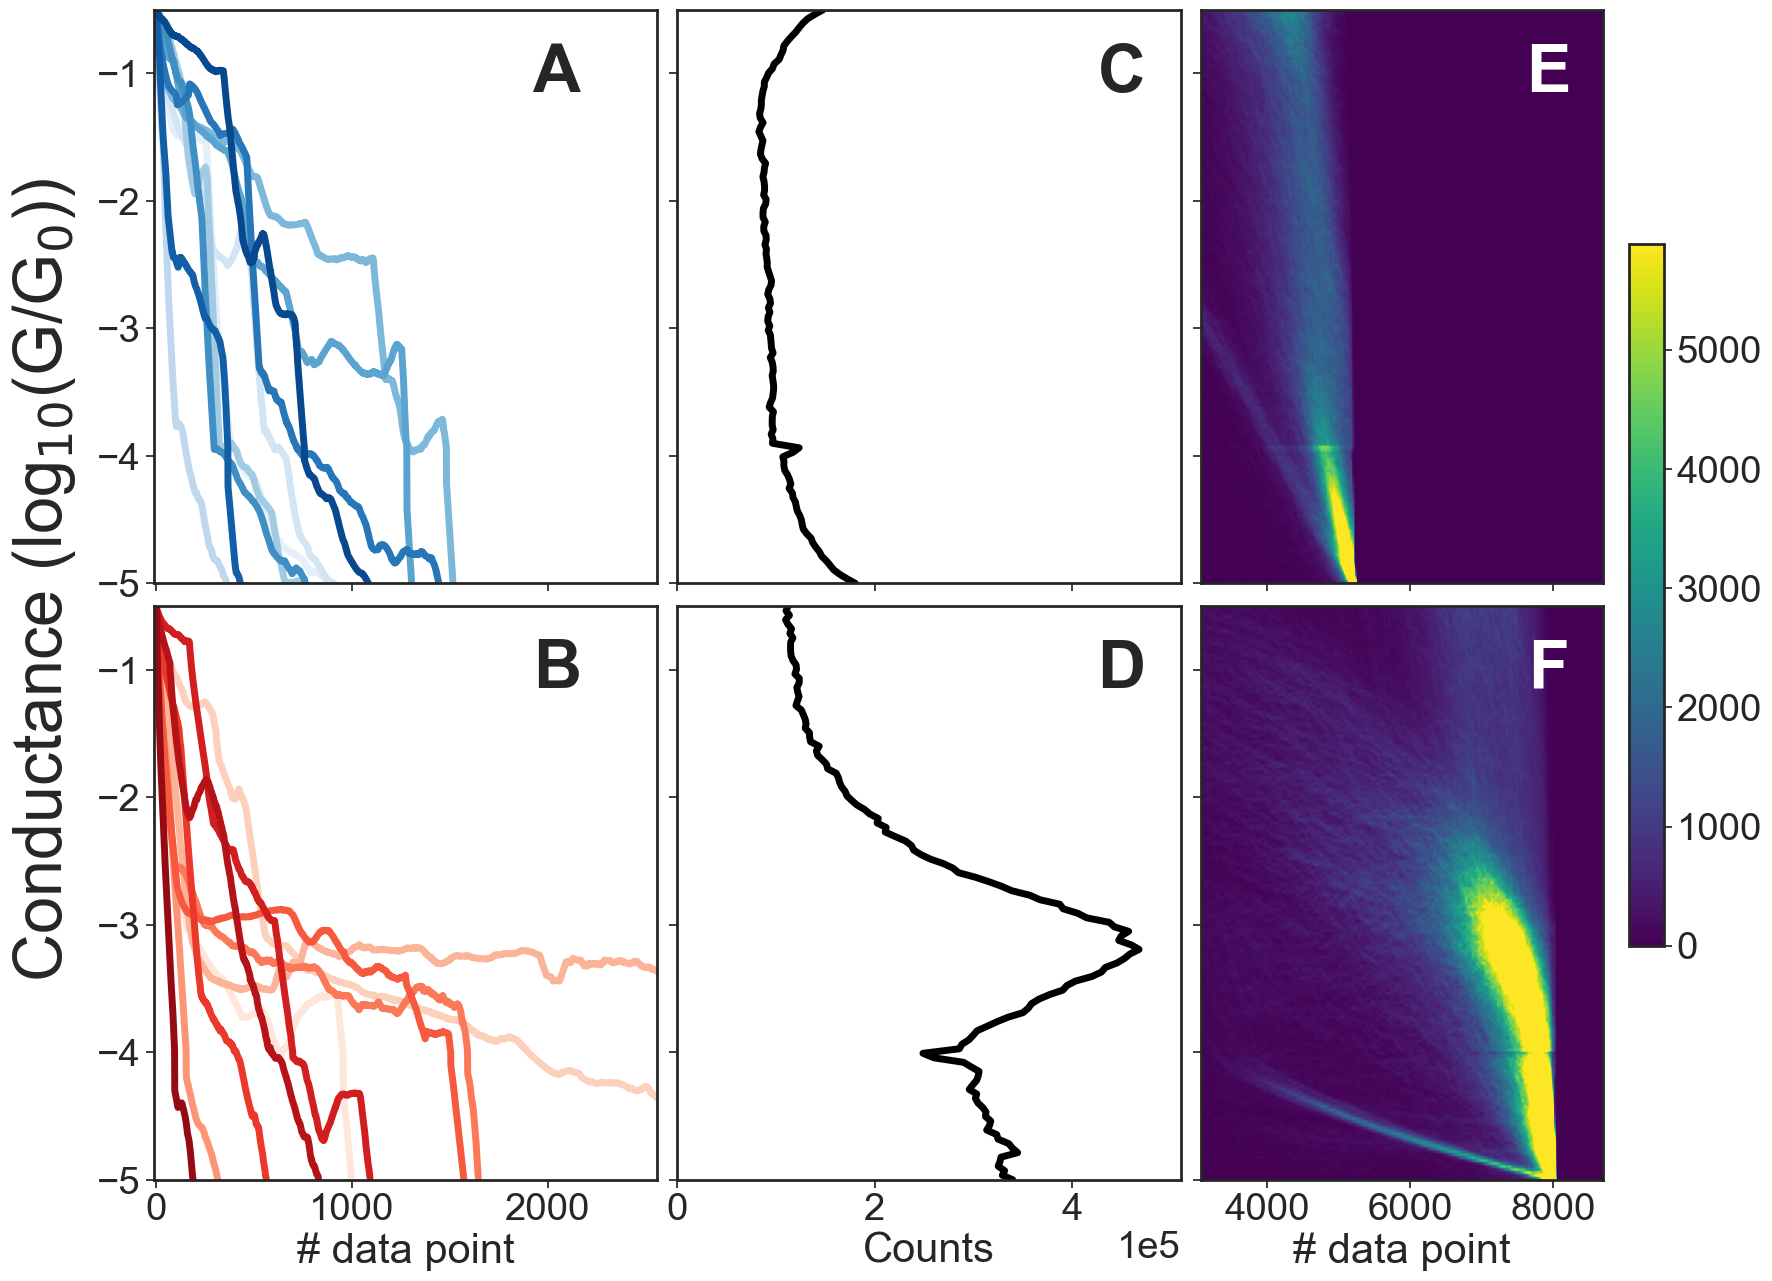

In [16]:
rng = np.random.default_rng(seed=RNG_STATE)
text_height = -1.
amount_traces = 10
blues = sns.color_palette("Blues", amount_traces)
reds = sns.color_palette("Reds", amount_traces)
colors = [blues, reds]

plot_length = 2048 + 512

# Visualization of both parts of the data set
fig, ax = plt.subplots(2, 3, figsize=(20, 30))
for idx, (dataset_hists, dataset_traces) in enumerate(
    [
        [plot_hist_blanks, p_blanks],
        [plot_hist_molecular, p_molecular],
    ]
):
    max_length = 0
    for c_i, trace in enumerate(dataset_traces[rng.integers(low=0, high=len(dataset_traces), size=amount_traces, endpoint=True)]):
        ax[idx, 0].plot(trace, c=colors[idx][c_i])
        if len(trace) > max_length:
            max_length = len(trace)
    ax[idx, 0].set_ylim(pre_info.plot_low, pre_info.plot_high)
    ax[idx, 0].set_xlim(-10, plot_length)
    ax[idx, 0].text(1024*2, text_height, ALPHABET[idx], va="center", ha="center", weight="bold", size=FONTSIZE)
    
    plot_hists = dataset_hists.sum(axis=0)
    ax[idx, 1].plot(
        plot_hists, np.linspace(pre_info.plot_low, pre_info.plot_high, dataset_hists.shape[1]), c="k"
    )
    ax[idx, 1].set_xlim(0, 5.1e5)
    ax[idx, 1].set_ylim(pre_info.plot_low, pre_info.plot_high)
    ax[idx, 1].text(4.5e5, text_height, ALPHABET[idx + 2], va="center", ha="center", weight="bold", size=FONTSIZE)

    bins_2d = 128 + 64
    hist_2d = np.zeros((bins_2d, bins_2d))
    
    # without alignment
    # vmax = 2048
    # for trace in tqdm(dataset_traces):
    #     H, *_ = np.histogram2d(
    #         trace, np.arange(len(trace)), bins=bins_2d, range=[[pre_info.plot_low, pre_info.plot_high], [0, plot_length]]
    #     )
    #     hist_2d += H

    # im = ax[idx, 2].imshow(
    #     hist_2d, vmin=0, vmax=vmax, origin="lower", cmap="viridis", extent=[0, plot_length, pre_info.plot_low, pre_info.plot_high], aspect="auto"
    # )
    # ax[idx, 2].text(
    #     2048 - 256, text_height, ALPHABET[idx + 4], va="center", ha="center", weight="bold", size=FONTSIZE, c="white"
    # )

    # with alignment
    vmax = 2048*3 - 256
    shift = 1024*6
    crossovers = []
    for trace in dataset_traces:
        co = np.argwhere(trace < -5)
        if len(co) > 1:
            crossovers.append(co[0][0])
        else:
            crossovers.append(len(trace))
    max_co = np.max(crossovers)
    for trace, co in zip(dataset_traces, crossovers):
        embedded = np.zeros(len(trace) + max_co)
        embedded[max_co - co:(max_co - co) + len(trace)] = trace
        H, *_ = np.histogram2d(embedded, np.arange(len(embedded)), bins=bins_2d, range=[[pre_info.plot_low, pre_info.plot_high], [1024*3, plot_length + shift]])
        hist_2d += H
    im = ax[idx, 2].imshow(
        hist_2d, vmin=0, vmax=vmax, origin="lower", cmap="viridis", extent=[1024*3, plot_length + shift, pre_info.plot_low, pre_info.plot_high], aspect="auto"
    )
    ax[idx, 2].text(
        shift + 1024 + 512 + 256, text_height, ALPHABET[idx + 4], va="center", ha="center", weight="bold", size=FONTSIZE, c="white"
    )

    if idx == 0:
        ax[idx, 0].set_xticklabels([])
        ax[idx, 1].set_xticklabels([])
        ax[idx, 2].set_xticklabels([])

    ax[idx, 1].set_yticklabels([])
    ax[idx, 2].set_yticklabels([])
    if idx == 1:
        ax[idx, 0].set_xlabel("# data point")
        ax[idx, 1].set_xlabel("Counts")
        ax[idx, 2].set_xlabel("# data point")
        ax[idx, 1].ticklabel_format(axis="x", scilimits=[-5, 4])

fig.text(0.07, 0.31, CONDUCTANCE_LABEL, va="center", ha="center", rotation="vertical", fontsize=FONTSIZE)
fig.subplots_adjust(wspace=0.04, top=0.5, hspace=0.04)
fig.colorbar(im, ax=ax[:, 2], shrink=.6)
fig.savefig("hists.pdf")
plt.show()

In [6]:
from sklearn.svm import OneClassSVM
from sklego.mixture import GMMOutlierDetector
# from pyod.models.auto_encoder import AutoEncoder
# from pyod.models.deep_svdd import DeepSVDD
# from pyod.models.vae import VAE

model_ocsvm_rbf = OneClassSVM(kernel="rbf", nu=0.01, gamma=0.0009)
model_ocsvm_linear = OneClassSVM(kernel="linear", nu=0.01, gamma="scale")
# model_iso = IsolationForest(contamination=0.001)
model_gmm_1comp = GMMOutlierDetector(n_components=1, threshold=0.99, random_state=RNG_STATE)
model_gmm_3comp = GMMOutlierDetector(n_components=3, threshold=0.99, random_state=RNG_STATE)
model_gmm_4comp = GMMOutlierDetector(n_components=4, threshold=0.99, random_state=RNG_STATE)
model_gmm_6comp = GMMOutlierDetector(n_components=6, threshold=0.99, random_state=RNG_STATE)

# deep learning models
# epochs = 16
# model_simple_ae = AutoEncoder(epochs=epochs, hidden_activation="relu", contamination=0.1, random_state=RNG_STATE)
# model_deepsvdd_ae = DeepSVDD(use_ae=True, epochs=epochs, hidden_activation="relu", contamination=0.1, random_state=RNG_STATE)
# model_deepsvdd_noae = DeepSVDD(use_ae=False, epochs=epochs, hidden_activation="relu", contamination=0.1, random_state=RNG_STATE)
# model_vae = VAE(epochs=epochs, gamma=0.8, hidden_activation="relu", contamination=0.1, random_state=RNG_STATE)

models = [
    model_ocsvm_linear,
    model_ocsvm_rbf,
    model_gmm_1comp,
    model_gmm_3comp,
    model_gmm_4comp,
    model_gmm_6comp,

    # model_simple_ae,
    # model_deepsvdd_ae,
    # model_deepsvdd_noae,
    # model_vae,
]

In [7]:
features_blanks = hist_blanks2d
features_molecular = hist_molecular2d

The following code block takes a long time to run with the full dataset. Therefore, we have already provided labels from our publication run.

In [8]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# scaled_blanks = scaler.fit_transform(features_blanks)
# scaled_molecular = scaler.transform(features_molecular)
# predicted_labels = []
# for model in tqdm(models):
#     model = model.fit(scaled_blanks)

#     pred_labels = model.predict(scaled_molecular)
#     predicted_labels.append(pred_labels)
# np.save("./oc_labels.npy")

100%|██████████| 6/6 [04:21<00:00, 43.59s/it]


In [8]:
predicted_labels = np.load("./oc_labels.npy")

Amount predicted blanks: 8484
Amount predicted blanks: 9356
Amount predicted blanks: 21893
Amount predicted blanks: 12412
Amount predicted blanks: 7156
Amount predicted blanks: 3559


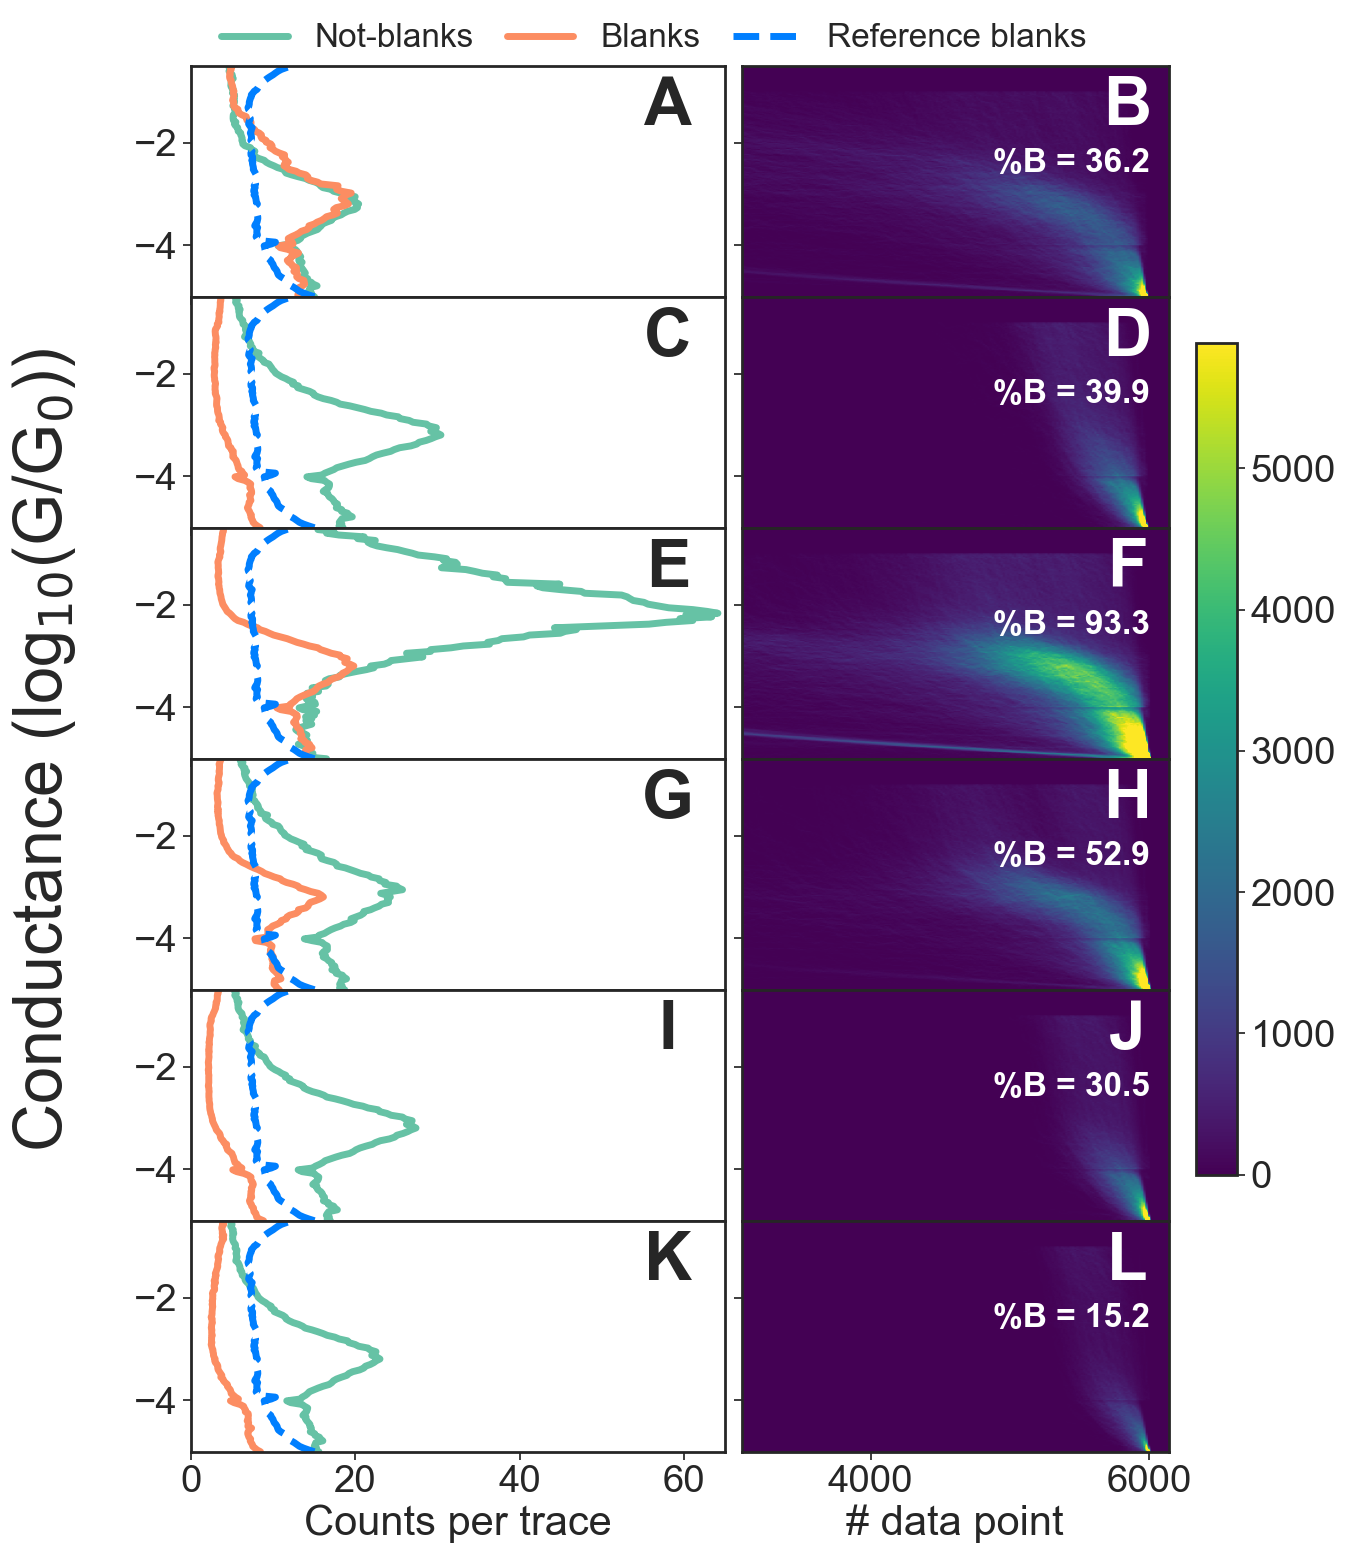

In [25]:
fig, ax = plt.subplots(len(models), 2, figsize=(14, 18))  # or 26
text_height = -1.3

ax1_yaxis = np.linspace(pre_info.plot_low, pre_info.plot_high, pre_info.bins)
max_ax1 = 0
percentages = []
max_co = 0
for idx, (pred_labels, model) in enumerate(zip(predicted_labels, models)):
    if model.__class__.__name__ in ["AutoEncoder", "VAE", "DeepSVDD"]:
        pred_labels[pred_labels == 0] = -1
        pred_labels *= -1

    # linear ocsvm has switched the pred_labels
    if model.__class__.__name__ == "OneClassSVM":
        if model.get_params()["kernel"] == "linear":
            pred_labels *= -1

    pred_mol = plot_hist_molecular[pred_labels == -1]
    ax[idx, 0].plot(
        pred_mol.sum(axis=0)/len(pred_mol),
        ax1_yaxis,
        label=f"Not-blanks" if idx == 0 else ""
    )
    pred_tun = plot_hist_molecular[pred_labels == 1]
    ax[idx, 0].plot(
        pred_tun.sum(axis=0)/len(pred_tun),
        ax1_yaxis,
        label=f"Blanks" if idx == 0 else ""
    )
    print(f"Amount predicted blanks: {len(pred_tun)}")
    percentages.append(1.0 - (len(hist_molecular) - len(pred_tun))/len(hist_molecular))

    ax[idx, 0].plot(
        plot_hist_blanks.sum(axis=0)/len(plot_hist_blanks),
        ax1_yaxis,
        c=c[0],
        linestyle="--",
        label="Reference blanks" if idx == 0 else "",
    )

    bins_2d = 128 + 64
    hist_2d = np.zeros((bins_2d, bins_2d))
    # without alignment
    # for trace in tqdm(fullwindow_molecular[pred_labels == 1], desc="Generating 2D histograms"):
    #     H, *_ = np.histogram2d(
    #         trace, np.arange(len(trace)), bins=bins_2d, range=[[pre_info.plot_low, pre_info.plot_high], [0, plot_length]]
    #     )
    #     hist_2d += H

    # im = ax[idx, 1].imshow(
    #     hist_2d,
    #     vmin=0,
    #     vmax=2048,
    #     origin="lower",
    #     cmap="viridis",
    #     extent=[0, plot_length, pre_info.plot_low, pre_info.plot_high],
    #     aspect="auto",
    # )
    # ax[idx, 1].text(
    #     plot_length - 300, text_height, ALPHABET[idx*2 + 1], va="center", ha="center", weight="bold", size=FONTSIZE, c="white"
    # )

    # with alignment
    vmax = 2048*3 - 256
    shift = 1024*3 + 512
    crossovers = []
    for trace in fullwindow_molecular[pred_labels == 1]:
        co = np.argwhere(trace < -5)
        if len(co) > 1:
            crossovers.append(co[0][0])
        else:
            crossovers.append(len(trace))
    max_co = np.max(crossovers) if np.max(crossovers) > max_co else max_co
    for trace, co in zip(fullwindow_molecular[pred_labels == 1], crossovers):
        embedded = np.zeros(len(trace) + max_co)
        embedded[max_co - co:(max_co - co) + len(trace)] = trace
        H, *_ = np.histogram2d(embedded, np.arange(len(embedded)), bins=bins_2d, range=[[pre_info.plot_low, pre_info.plot_high], [1024*3, plot_length + shift]])
        hist_2d += H
    im = ax[idx, 1].imshow(
        hist_2d, vmin=0, vmax=vmax, origin="lower", cmap="viridis", extent=[1024*3, plot_length + shift, pre_info.plot_low, pre_info.plot_high], aspect="auto"
    )
    ax[idx, 1].text(
        shift + plot_length - 300, text_height, ALPHABET[idx*2 + 1], va="center", ha="center", weight="bold", size=FONTSIZE, c="white"
    )
    
    if not idx == len(models) - 1:
        ax[idx, 0].set_xticklabels([])
        ax[idx, 1].set_xticklabels([])
    ax[idx, 1].set_yticklabels([])
    ax[idx, 0].set_ylim(pre_info.plot_low, pre_info.plot_high)
ax[0, 0].legend(frameon=False, loc="lower left", bbox_to_anchor=(0.0, 0.92, 1, 0), ncol=3, columnspacing=1., fontsize=FONTSIZE//2)

for idx, p in enumerate(percentages):
    # ax[idx, 0].text(11.5e4, text_height, ALPHABET[idx], va="center", ha="center", fontsize=FONTSIZE, weight="bold")
    ax[idx, 0].text(58, text_height, ALPHABET[idx*2], va="center", ha="center", fontsize=FONTSIZE, weight="bold")
    ax[idx, 1].text(shift + plot_length - 300 - 400, text_height - 1.1, f"%B = {p*100:.3}", va="center", ha="center", fontsize=FONTSIZE // 2, c="white", weight="bold")
    ax[idx, 0].set_xlim(0, 65)

ax[-1, 0].set_xlabel("Counts per trace")
ax[-1, 1].set_xlabel("# data point")
# fig.text(0.5, 0.08, "# Data points", va="center", ha="center")
fig.text(0.02, 0.5, CONDUCTANCE_LABEL, va="center", ha="center", rotation="vertical", fontsize=FONTSIZE)
fig.subplots_adjust(hspace=0.0, wspace=0.03)
fig.colorbar(im, ax=ax[:, 1], shrink=.6)
plt.savefig("./visual_perf.pdf")
plt.show()

## Plot length distribution

In [30]:
length_range = (0, 2048)
length_bins = 128

100%|██████████| 6/6 [00:00<00:00, 60.70it/s]


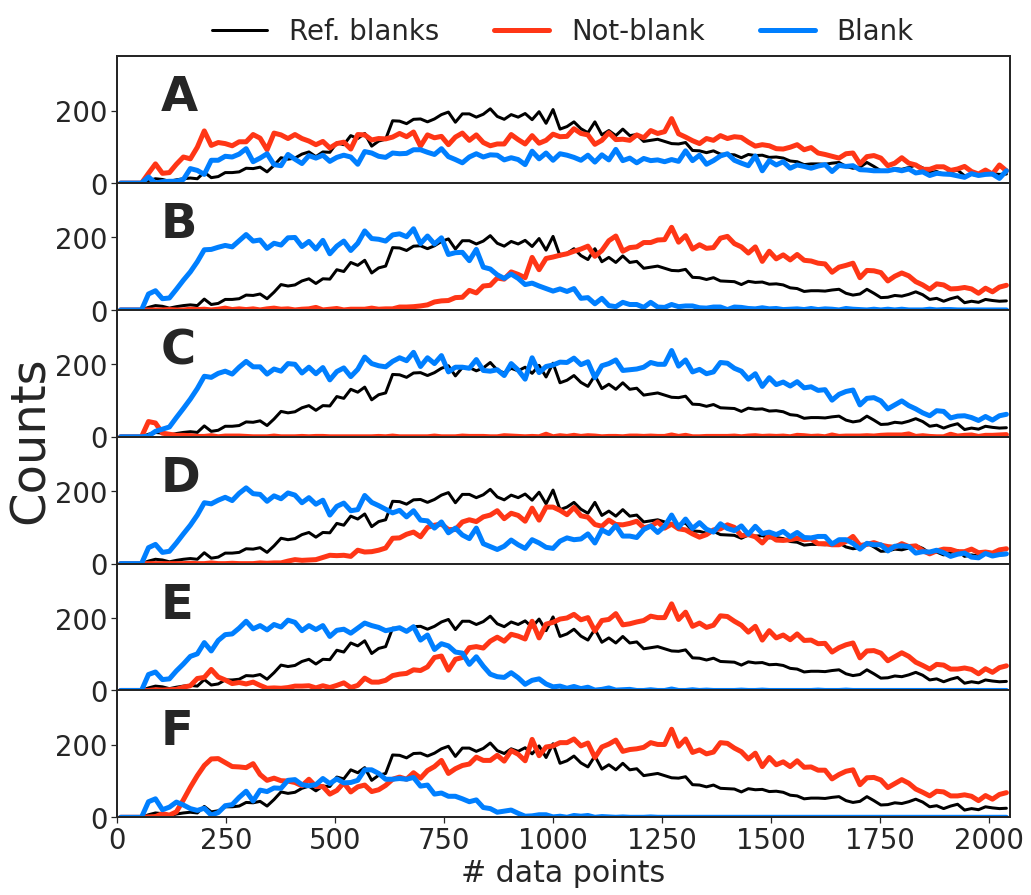

In [39]:
fig, ax = plt.subplots(len(models), 1, figsize=(16, 14), sharex=True, sharey=True)
pal = sns.color_palette("Set2", 12)
len_ref = np.histogram([len(x) for x in p_blanks], bins=length_bins, range=length_range)[0]
for idx, label_set in enumerate(tqdm(predicted_labels)):
    len_mol, binedges = np.histogram([len(x) for x in p_molecular[label_set == -1]], bins=length_bins, range=length_range)
    len_tun = np.histogram([len(x) for x in p_molecular[label_set == 1]], bins=length_bins, range=length_range)[0]

    binedges = (binedges[1:] + binedges[:-1])/2
    ax[idx].plot(binedges, len_ref, label="Ref. blanks", c="k", lw=3)
    ax[idx].plot(binedges, len_mol, label="Not-blank", c=c[1])
    ax[idx].plot(binedges, len_tun, label="Blank", c=c[0])
    ax[idx].text(100, 200, ALPHABET[idx], fontsize=FONTSIZE, weight="bold")
ax[0].legend(frameon=False, ncol=3, bbox_to_anchor=[1, 1, -0.08, 0.5])
plt.xlim(length_range)
plt.ylim(0, 350)
plt.xlabel("# data points")
fig.text(0.05, 0.5, "Counts", va="center", ha="center", rotation="vertical", fontsize=FONTSIZE)

fig.subplots_adjust(hspace=0.0)
fig.savefig("length_distributions.pdf")
plt.show()

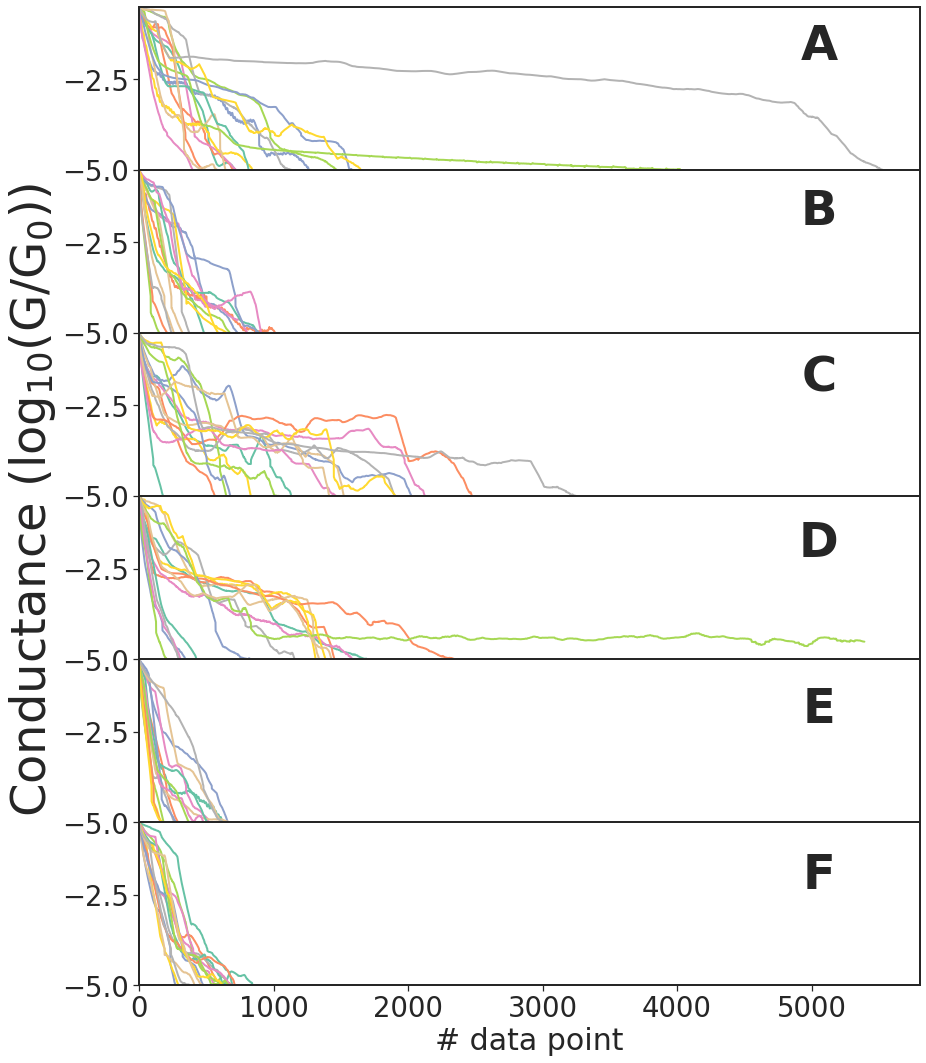

In [48]:
cm_blues = plt.get_cmap("Blues")
cm_reds = plt.get_cmap("Reds")

bins_2d = 64
x, y = np.meshgrid(np.arange(0, bins_2d), np.arange(0, bins_2d))
fig, axes = plt.subplots(len(models), 1, figsize=(14, 18), sharex=True, sharey=True)
for idx, (ax, label_set) in enumerate(zip(axes, predicted_labels)):
    util_functions.plot_individual_traces(p_molecular[label_set == 1], ax, size=16, rng=rng, lw=2)
    fig.text(0.8, .85 - idx*.128, ALPHABET[idx], weight="bold", size=FONTSIZE, va="center", ha="center")

plt.subplots_adjust(hspace=0.0)
plt.xlim(-4)
plt.ylim(pre_info.plot_low, pre_info.plot_high)
axes[-1].set_xlabel("# data point")
fig.text(0.02, 0.5, CONDUCTANCE_LABEL, ha="center", va="center", rotation="vertical", fontsize=FONTSIZE)
plt.savefig("predicted_tunneling_visualized.pdf")
plt.show()

100%|██████████| 12010/12010 [00:02<00:00, 4460.85it/s]


(12010, 4)


100%|██████████| 8484/8484 [00:02<00:00, 4065.47it/s]
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


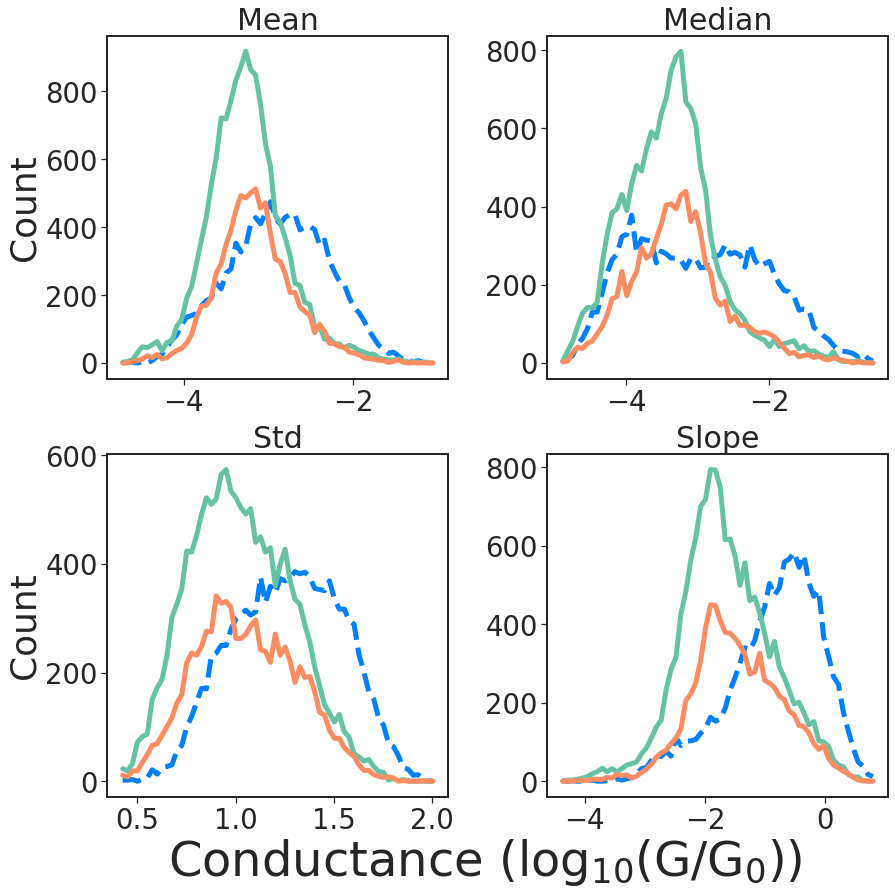

100%|██████████| 14109/14109 [00:03<00:00, 3641.54it/s]


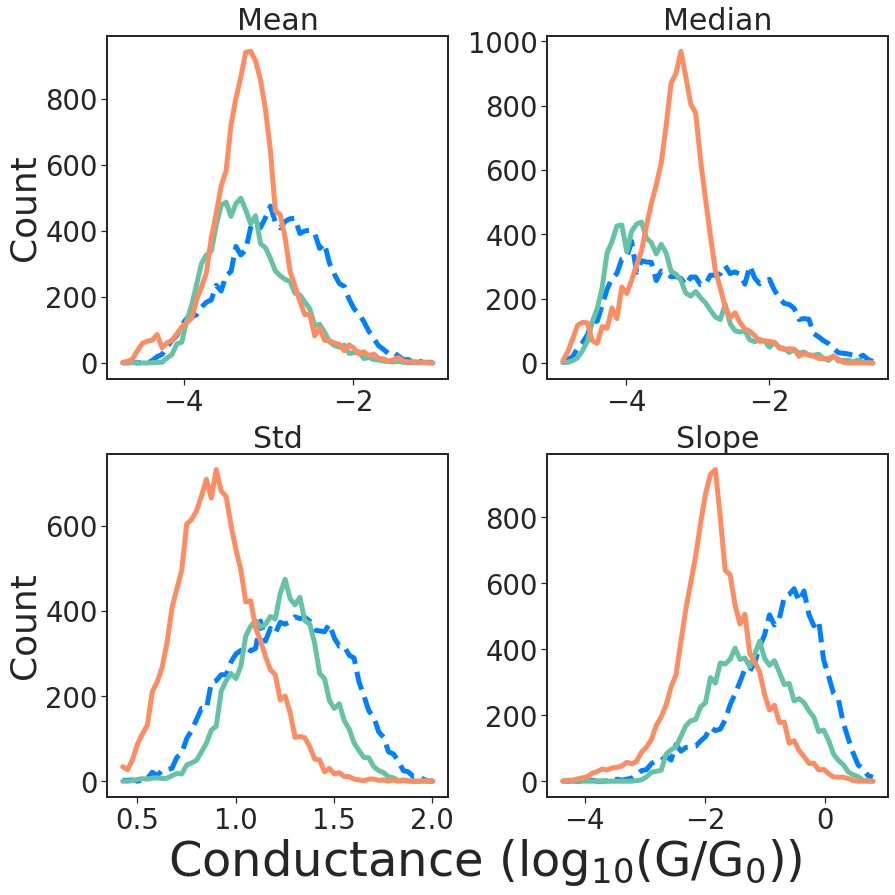

100%|██████████| 1572/1572 [00:00<00:00, 2497.54it/s]


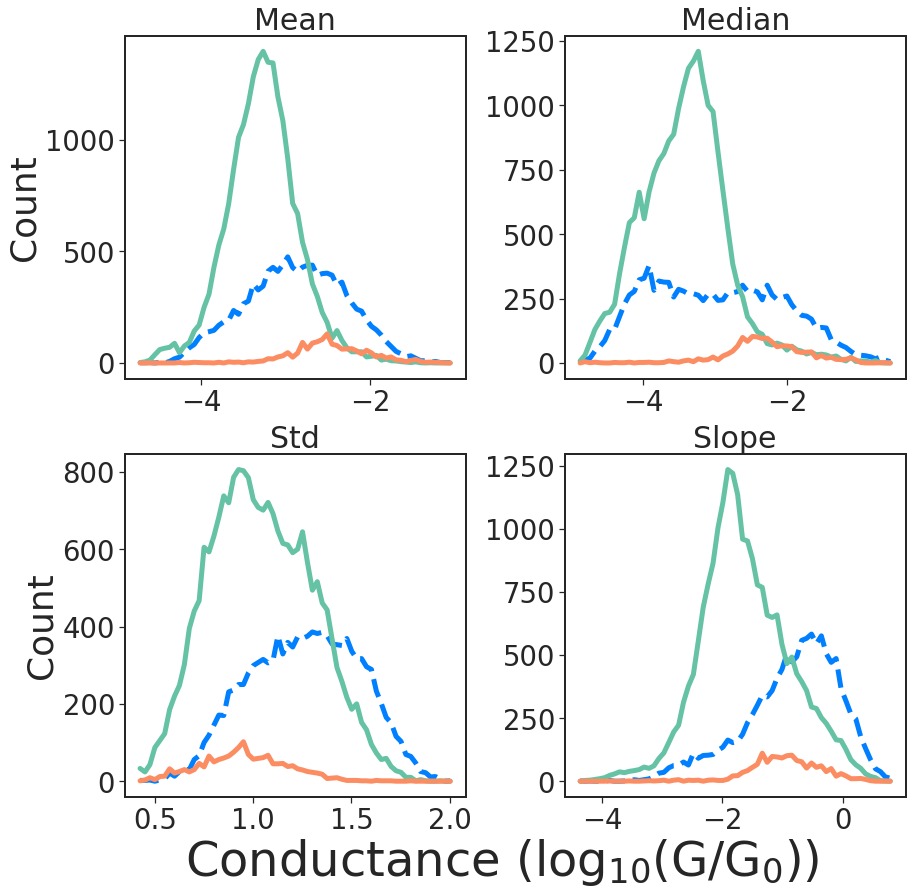

100%|██████████| 11053/11053 [00:03<00:00, 3677.14it/s]


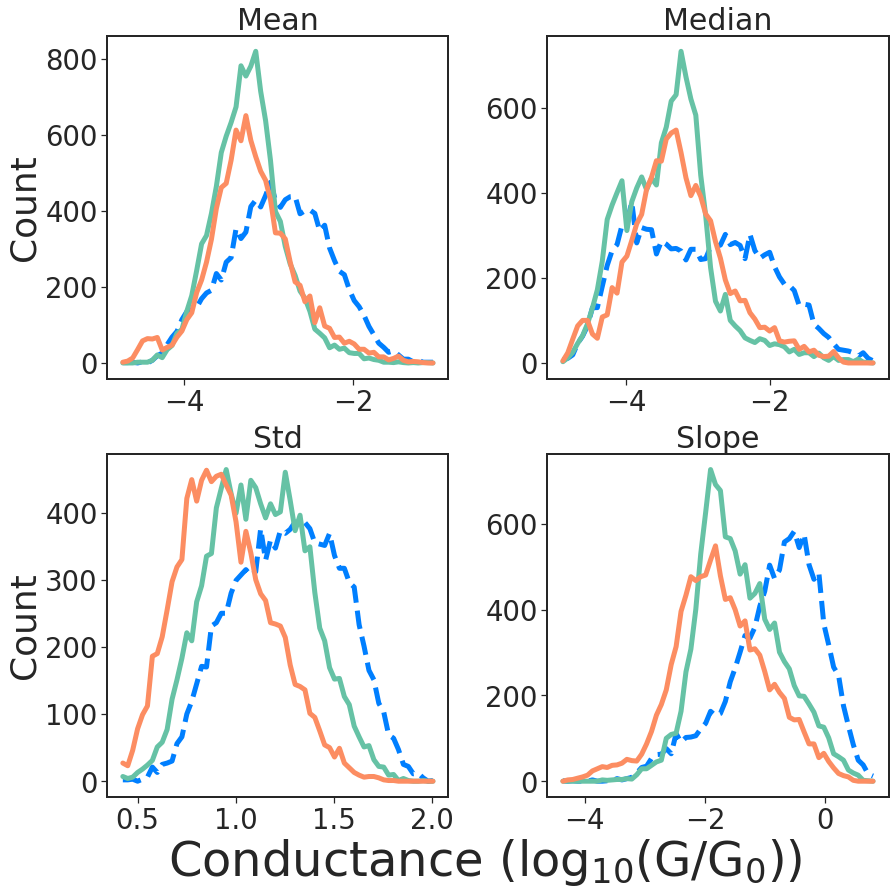

100%|██████████| 16309/16309 [00:04<00:00, 3658.91it/s]


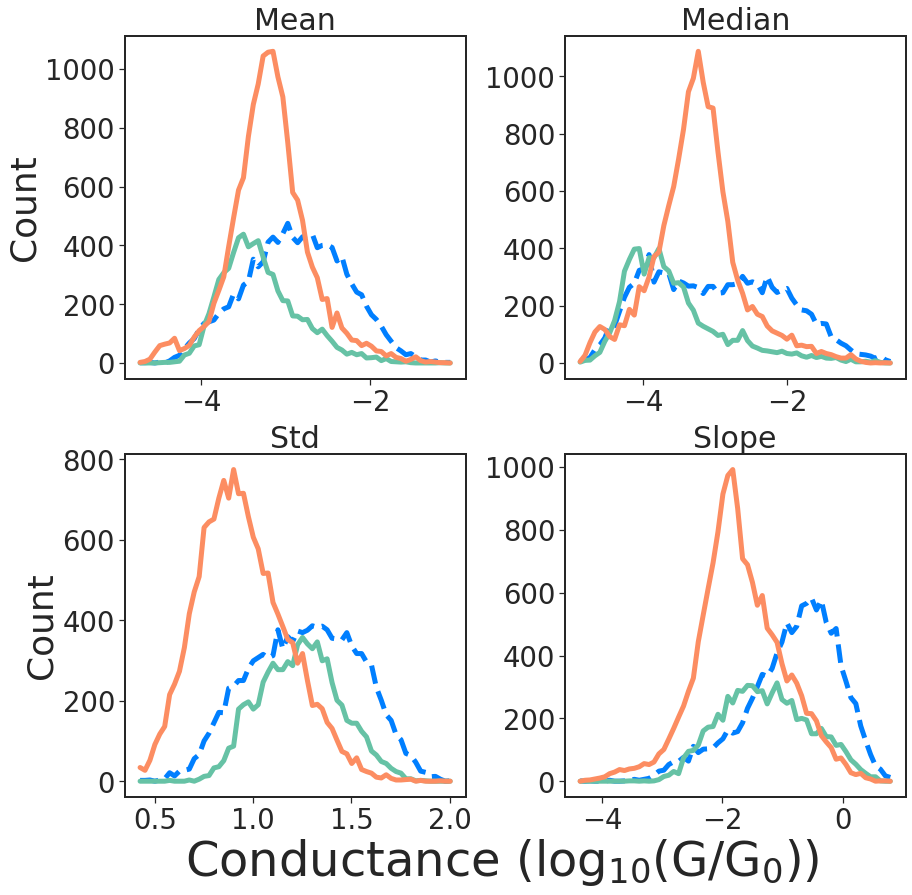

100%|██████████| 19906/19906 [00:05<00:00, 3979.68it/s]


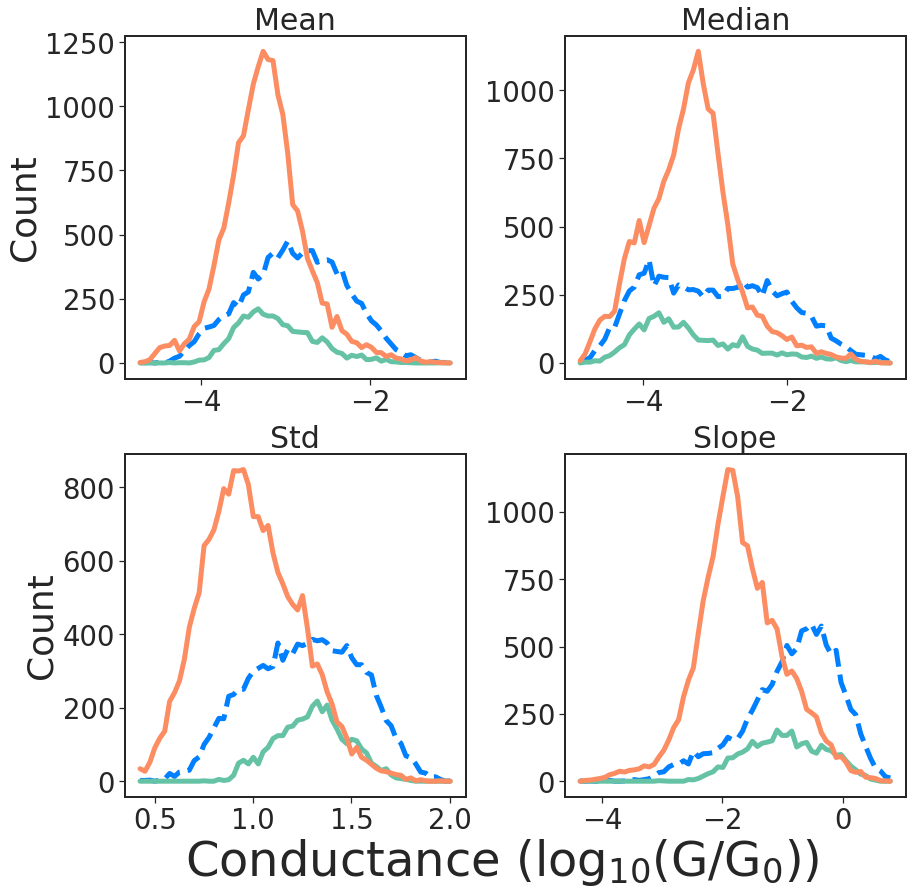

In [10]:
titles = [
    # "Length",
    "Mean",
    "Median",
    "Std",
    # "Offset",
    "Slope",
]
summary_blanks = util_functions.summary_statistics(p_blanks)
print(summary_blanks.shape)
for j, label_set in enumerate(predicted_labels):
    summary_pred_blanks = util_functions.summary_statistics(p_molecular[label_set == 1])
    summary_pred_not = util_functions.summary_statistics(p_molecular[label_set == -1])
    fig, axes = plt.subplots(2, 2, figsize=(14, 14))
    axes = axes.ravel()
    for i, title in enumerate(titles):
        min_range = np.min(summary_blanks[:, i])
        max_range = np.max(summary_blanks[:, i])
        hist, binedges = np.histogram(summary_blanks[:, i], bins=64, range=(min_range, max_range))
        binedges = (binedges[1:] + binedges[:-1])/2
        axes[i].plot(binedges, hist, label="Ref. blanks", linestyle="--", c=c[0])

        hist, binedges = np.histogram(summary_pred_blanks[:, i], bins=64, range=(min_range, max_range))
        binedges = (binedges[1:] + binedges[:-1])/2
        axes[i].plot(binedges, hist, label="Pred. blanks")

        hist, binedges = np.histogram(summary_pred_not[:, i], bins=64, range=(min_range, max_range))
        binedges = (binedges[1:] + binedges[:-1])/2
        axes[i].plot(binedges, hist, label="Pred. not-blanks")

        fs = 36
        if i % 2 == 0:
            axes[i].set_ylabel("Count", fontsize=fs)

        axes[i].set_title(title)
    fig.text(0.5, 0.06, CONDUCTANCE_LABEL, ha="center", va="center", fontsize=FONTSIZE)
    plt.subplots_adjust(hspace=.22, wspace=0.29)
    plt.savefig(f"summary_statistics_{j}")
    plt.show()